In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf, 
                        create_directory, read_directory_files, get_subdirectories,
                        get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                       )
from xml_document_info import (get_xml_info)
from box_spacings_operation import (update_horizontal_spacings_v1, update_vertical_spacings_v1)
from box_conditions_evaluation import (are_vlines_too_close, are_vlines_close_enough,
                                       are_hlines_too_close, are_hlines_close_enough,
                                       are_hlines_aligned, are_lines_fonts_similar,
                                       arrange_grouped_line_indices, are_hlines_superscript,
                                       are_hlines, are_vlines)
from box_horizontal_operation import (merge_hori_boxes_close)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont


## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [3]:
base_dir   = '/Users/kd/Workspace/python/CV/DRAW_BOXES/data/'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = '1.02.2020.pdf'


In [4]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
print(xml_files, "\n\n")

image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
print(image_files)

Extracted pdf images [/Users/kd/Workspace/python/CV/DRAW_BOXES/data/output/1.02.2020/images] 


Extracted xml of digital PDF [/Users/kd/Workspace/python/CV/DRAW_BOXES/data/output/1.02.2020/pdttohtml] 


['/Users/kd/Workspace/python/CV/DRAW_BOXES/data/output/1.02.2020/pdttohtml/1.02.2020.xml'] 


['/Users/kd/Workspace/python/CV/DRAW_BOXES/data/output/1.02.2020/images/1.02.20200001-1.jpg', '/Users/kd/Workspace/python/CV/DRAW_BOXES/data/output/1.02.2020/images/1.02.20200001-2.jpg']


In [5]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (2) in file (1.02.2020.xml)


In [6]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 5.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [7]:
file_index = 0

img        = image_files[file_index]
df         = xml_dfs[file_index]


## Vertical box merging operations

In [12]:
def merge_vert_boxes(df, boxes, debug=False):
    t_ts       = []
    t_ls       = []
    t_ws       = []
    t_hs       = []
    texts      = []
    f_sizes    = []
    f_familys  = []
    f_colors   = []
    
    if debug:
        print('merge_vert_boxes: %s \n---------\n' % (str(boxes)))
        
    for box_item in boxes:
        line_indices, connection_type = box_item
        
        if connection_type == 'NOT_CONNECTED':
            for line_index in line_indices:
                t_ts.append(df.iloc[line_index]['text_top'])
                t_ls.append(df.iloc[line_index]['text_left'])
                t_hs.append(df.iloc[line_index]['text_height'])
                t_ws.append(df.iloc[line_index]['text_width'])
                texts.append(df.iloc[line_index]['text'])
                f_sizes.append(df.iloc[line_index]['font_size'])
                f_familys.append(df.iloc[line_index]['font_family'])
                f_colors.append(df.iloc[line_index]['font_color'])
        else:
            first_line_index = line_indices[0]
            last_line_index  = line_indices[-1]
            
            t_ts.append(df.iloc[first_line_index]['text_top'])
            
            min_left         = df.loc[first_line_index:last_line_index, 'text_left'].min()
            t_ls.append(min_left)

            t_hs.append(df.iloc[last_line_index]['text_top'] + df.iloc[last_line_index]['text_height'] - df.iloc[first_line_index]['text_top'])

            max_width        = max(df.iloc[first_line_index]['text_left']+df.iloc[first_line_index]['text_width'],
                                  df.iloc[last_line_index]['text_left']+df.iloc[last_line_index]['text_width']) - min_left
            t_ws.append(max_width)

            connected_text = ''
            for line_index in line_indices:
                connected_text = connected_text +  df.iloc[line_index]['text'] + ' '
            texts.append(connected_text)
            f_sizes.append(df.iloc[first_line_index]['font_size'])
            f_familys.append(df.iloc[first_line_index]['font_family'])
            f_colors.append(df.iloc[first_line_index]['font_color'])

    box_df = pd.DataFrame(list(zip(t_ts, t_ls, t_ws, t_hs, texts, 
                                   f_sizes, f_familys, f_colors)),
                          columns =['text_top', 'text_left', 'text_width', 'text_height', 'text', 
                                    'font_size', 'font_family', 'font_color'])
    
    box_df = update_horizontal_spacings_v1(box_df)
    box_df = update_vertical_spacings_v1(box_df)
    
    return box_df

def merge_vert_boxes_close(df, configs, debug=False):
    new_df             = df.copy()
    new_df             = new_df.reset_index(drop=True)
    
    connections        = []
    index_grams        = get_ngram(list(new_df.index.values), window_size=2)
    for index_gram in index_grams:
        if are_lines_fonts_similar(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
            and \
            are_vlines_too_close(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
        :
            connections.append((index_gram[1], index_gram[0], 'CONNECTED'))
        else:
            connections.append((index_gram[1], index_gram[0], 'NOT_CONNECTED'))
    
    if debug:
        print("line connections (merge_vert_boxes_close) : %s \n----\n" % (str(connections)))
    
    grouped_lines = arrange_grouped_line_indices(connections, debug=debug)
    new_df        = merge_vert_boxes(new_df, grouped_lines, debug=debug)
    
    '''
        - too close vertical lines have been merged till here
        - checking for overlap condition
    '''
    
#     connections        = []
#     index_grams        = get_ngram(list(new_df.index.values), window_size=2)
#     for index_gram in index_grams:
#         if are_lines_fonts_similar(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
#             and \
#             are_vlines(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
#         :
#             connections.append((index_gram[1], index_gram[0], 'CONNECTED'))
#         else:
#             connections.append((index_gram[1], index_gram[0], 'NOT_CONNECTED'))
    
#     grouped_lines = arrange_grouped_line_indices(connections, debug=debug)
#     box_df        = merge_vert_boxes(new_df, grouped_lines, debug=debug)
#     print('total records: %d, after merging records %d' % (new_df.shape[0], box_df.shape[0]))
    
    return box_df

total records: 37, after merging records 30
total records: 28, after merging records 15


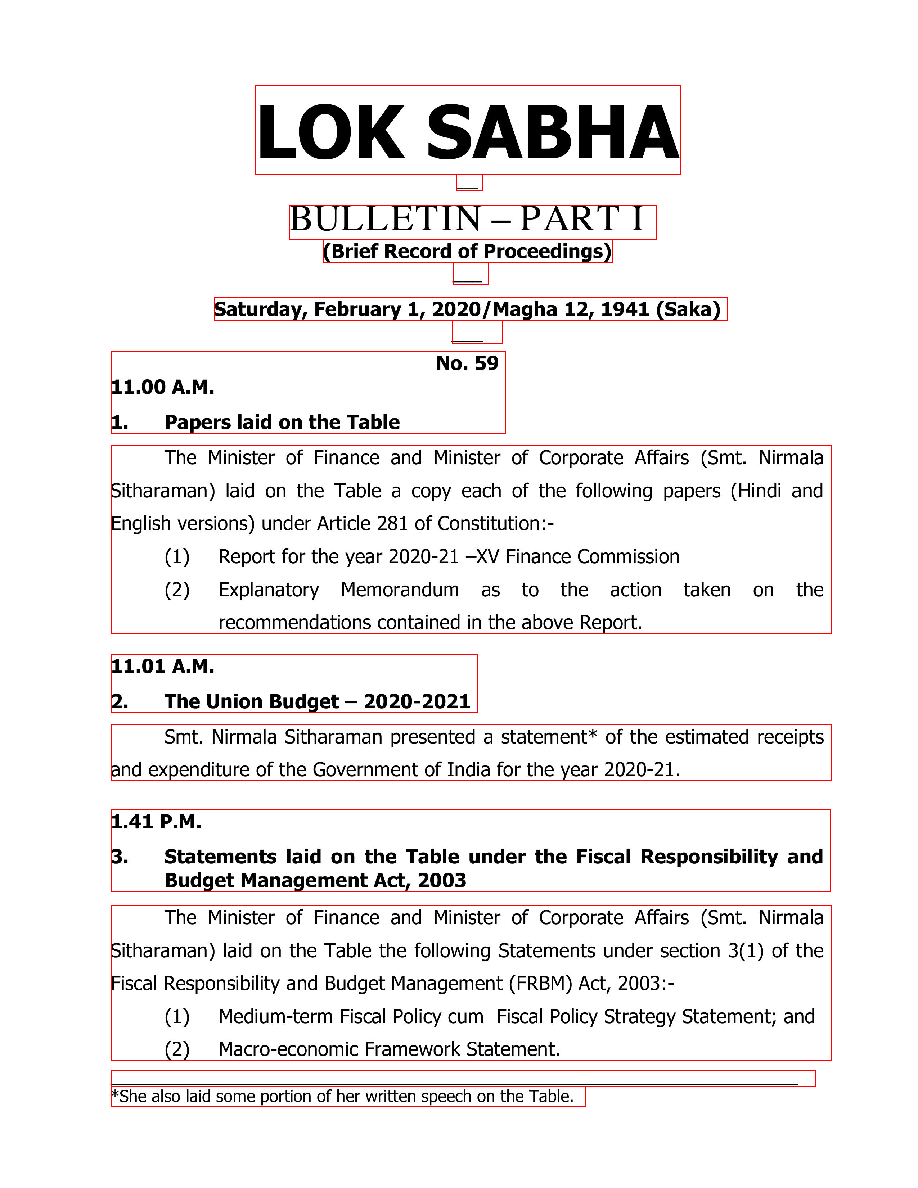

In [13]:
h_df = merge_hori_boxes_close(df, document_configs, debug=False)

v_df = merge_vert_boxes_close(h_df, document_configs, debug=False)

draw_box(img, page_width, page_height, v_df, color='red')
# show_df(v_df)

In [12]:
show_df(h_df)

,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,horizontal_space,vertical_space
0,85,255,425,89,LOK SABHA,73,"ABCDEE+Tahoma,Bold",#000000,0,0
1,174,456,26,16,___,13,ABCDEE+Tahoma,#000000,0,0
2,205,289,367,34,BULLETIN – PART I,37,"Times New Roman,Bold",#000000,0,15
3,239,323,289,23,(Brief Record of Proceedings),19,"ABCDEE+Tahoma,Bold",#000000,0,0
4,262,453,35,22,___,18,ABCDEE+Tahoma,#000000,0,0
5,297,214,513,23,"Saturday, February 1, 2020/Magha 12, 1941 (Saka)",19,"ABCDEE+Tahoma,Bold",#000000,0,13
6,320,452,50,23,___,19,ABCDEE+Tahoma,#000000,0,0
7,351,436,69,23,No. 59,19,"ABCDEE+Tahoma,Bold",#000000,0,8
8,375,111,104,23,11.00 A.M.,19,"ABCDEE+Tahoma,Bold",#000000,0,1
9,410,111,295,23,1. Papers laid on the Table,19,"ABCDEE+Tahoma,Bold",#000000,0,12
